In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from wordcloud import WordCloud
from collections import Counter
from nltk.stem import PorterStemmer, LancasterStemmer

In [2]:
def read_articles(file_name):
    with open(file_name, "r") as handle:
        article_all_lines = handle.readlines()
    
    article_all_lines = [line.replace("\n", "") for line in article_all_lines]
    
    start_art_idx = []
    for idx, line in enumerate(article_all_lines):
        if line.startswith("@"):
            start_art_idx.append(idx)
    
    idx_parirs = list(zip(start_art_idx[:-1], start_art_idx[1:])) + [(start_art_idx[-1], None)]
    #print(idx_parirs)
    articles = []
    for s_idx, e_idx in idx_parirs:
        articles.append(article_all_lines[s_idx: e_idx])
    return articles

In [3]:
def look_for_field(field, lines_per_article):
    s_idx = -1
    for idx, line in enumerate(lines_per_article):
        if line.startswith(field + " "):
            s_idx = idx
    
    e_idx = s_idx
    idx = s_idx
    while True:
        idx += 1
        if lines_per_article[idx].startswith(" "):
            e_idx = idx
        else:
            break
    e_idx += 1
    return s_idx, e_idx

In [4]:
def extract_field(field, lines_per_article):
    s_idx, e_idx = look_for_field(field, lines_per_article)
    if s_idx == -1:
        return None
    
    extracted_lines = lines_per_article[s_idx: e_idx]
    
    extracted_lines = [line.replace(field, "") for line in extracted_lines]
    extracted_lines = [line.replace("=", "") for line in extracted_lines]

    extracted_lines = [line.replace("{", "") for line in extracted_lines]
    extracted_lines = [line.replace("},", "") for line in extracted_lines]
    extracted_lines = [line.replace("}", "") for line in extracted_lines]
    
    extracted_lines = [line.strip() for line in extracted_lines]
    
    return "\n".join(extracted_lines)

In [5]:
def extract_fields(fields, lines_per_article):
    art = {field: extract_field(field, lines_per_article) for field in fields}
    return art

In [6]:
def create_pub_df(bib_file, fields):
    articles = read_articles(bib_file)
    df = [extract_fields(fields, art) for art in articles]
    return pd.DataFrame(df)

In [7]:
def remove_newlines_char(df, cols):
    for col in cols:
        df[col] = df[col].str.replace("\n", " ")
    return df

In [8]:
def remove_backward_slash(df, cols):
    for col in cols:
        df[col] = df[col].str.replace("\\", "")
    return df

In [9]:
def impute_year_none(df):
    is_year_none = df["Year"].isna()
    df.loc[is_year_none, "Year"] = df.loc[is_year_none, "Early Access Date"].apply(lambda s: s.split()[-1])
    return df

In [10]:
def nr_coauth(df, new_col_name):
    df[new_col_name] = 0
    auth_not_nan = ~df["Author"].isna()
    df.loc[auth_not_nan, new_col_name] = df.loc[auth_not_nan, "Author"].apply(lambda s: len(s.split("and")))
    return df

In [11]:
def nr_emails(df, new_col_name):
    df[new_col_name] = 0
    email_not_na = ~df["Author-Email"].isna()
    df.loc[email_not_na, new_col_name] = df.loc[email_not_na, "Author-Email"].apply(lambda s: len(s.split()))
    return df

In [12]:
def has_email(df, new_col_name, emails):
    df[new_col_name] = False
    
    email_not_na = ~df["Author-Email"].isna()
    
    for email in emails:
        df.loc[email_not_na, new_col_name] = df.loc[email_not_na, new_col_name] | df.loc[
            email_not_na, "Author-Email"].apply(lambda s: email in s)
    return df

In [13]:
def _is_reprint_auth(aff_str, auth_name):
    lines = aff_str.split("\n")
    for line in lines:
        if (auth_name in line) and ("(Reprint Author)" in line):
            return True
    return False

def is_reprint_auth(df, new_col_name, auth_name):
    df[new_col_name] = False
    aff_not_na = ~df["Affiliation"].isna()
    df.loc[aff_not_na, new_col_name] = df.loc[aff_not_na, "Affiliation"].apply(
        lambda s: _is_reprint_auth(s, auth_name))
    return df

In [14]:
def _reprint_auth_names(aff_str):
    lines = aff_str.split("\n")
    names = []
    for line in lines:
        if "(Reprint Author)" in line:
            names.append(line.split("(Reprint Author)")[0].strip())
    names = np.unique(names)
    return "\n".join(names)

def reprint_auth_names(df, new_col_name):
    df[new_col_name] = False
    aff_not_na = ~df["Affiliation"].isna()
    df.loc[aff_not_na, new_col_name] = df.loc[aff_not_na, "Affiliation"].apply(
        lambda s: _reprint_auth_names(s))
    return df

In [15]:
def nr_corr_auth(df, new_col_name):
    df[new_col_name] = False
    aff_not_na = ~df["Affiliation"].isna()
    df.loc[aff_not_na, new_col_name] = df.loc[aff_not_na, "Corr_Auth_Names"].apply(lambda s: len(s.split("\n")))
    return df

In [16]:
def _is_aff(aff_str, auth_name, inst_name_aliases):
    assert isinstance(inst_name_aliases, list), "inst_name_aliases must be a list"
    lines = aff_str.split("\n")
    for line in lines:
        for inst_name in inst_name_aliases:
            if (auth_name in line) and (inst_name in line):
                return True
    return False

def is_affiliated_with(df, new_col_name, auth_name, inst_name):
    df[new_col_name] = False
    aff_not_na = ~df["Affiliation"].isna()
    df.loc[aff_not_na, new_col_name] = df.loc[aff_not_na, "Affiliation"].apply(
        lambda s: _is_aff(s, auth_name, inst_name))
    return df

In [17]:
BIB_FILE = "savedrecs.bib"
FIELDS = ["Author", "Title", "Journal", "Year", "Abstract", 
          "Keywords-Plus", "Keywords", "Research-Areas", "Web-of-Science-Categories",
          "Author-Email", "Journal-ISO", "Cited-References", "Early Access Date", "Affiliation"]
df = create_pub_df(BIB_FILE, FIELDS)

cols_to_rm_newline = [col for col in df.columns if col not in ["Cited-References", "Affiliation"]]
df = remove_newlines_char(df, cols_to_rm_newline)
df = remove_backward_slash(df, df.columns)
df = impute_year_none(df)
df["Year"] = df["Year"].astype("int")

df = nr_coauth(df, "Nr_Co_Author")

df = nr_emails(df, "Nr_Emails")

df = has_email(df, "DMH_has_email", ["dominhhoat@tdtu.edu.vn", "hoat@ifuap.buap.mx"])

df = is_reprint_auth(df, "Is_DMH_Corr_Auth", "Hoat")

df = reprint_auth_names(df, "Corr_Auth_Names")

df = nr_corr_auth(df, "Nr_Corr_Auth")

df["Is_DMH_Sole_Corr_Auth"] = df["Is_DMH_Corr_Auth"] & (df["Nr_Corr_Auth"] == 1)

df["Is_DMH_Co-Corr_Auth"] = df["Is_DMH_Corr_Auth"] & (df["Nr_Corr_Auth"] > 1)

df = is_affiliated_with(df, "Is_DMH_at_TDTU", "Hoat", ["Ton Duc Thang", "Ton Duc Thong"])

df.head()

,Abstract,Affiliation,Author,Author-Email,Cited-References,Early Access Date,Journal,Journal-ISO,Keywords,Keywords-Plus,...,Year,Nr_Co_Author,Nr_Emails,DMH_has_email,Is_DMH_Corr_Auth,Corr_Auth_Names,Nr_Corr_Auth,Is_DMH_Sole_Corr_Auth,Is_DMH_Co-Corr_Auth,Is_DMH_at_TDTU
0,We study comprehensively the uniform strain ef...,"Hoat, DM (Reprint Author), Ton Duc Thang Univ,...","Naseri, Mosayeb and Hoat, D. M. and Ponce-Pere...",m.naseri@iauksh.ac.ir dominhhoat@tdtu.edu.vn r...,"Ahmad M, 2017, J ALLOY COMPD, V705, P828, DOI ...",None,CHEMICAL PHYSICS,Chem. Phys.,FP-LAPW calculations; CsPbCl3; Strain effect; ...,ORGANIC-INORGANIC PEROVSKITES; THERMODYNAMIC P...,...,2020,5,4,True,True,"Hoat, DM",1,True,False,True
1,Two dimensional monolayer semiconductors play ...,"Naseri, M (Reprint Author), Islamic Azad Univ,...","Naseri, Mosayeb and Hoat, D. M. and Salehi, Kh...",m.naseri@iauksh.ac.ir dominhhoat@tdtu.edu.vn,"Balendhran S, 2015, SMALL, V11, P640, DOI 10.1...",None,JOURNAL OF MOLECULAR GRAPHICS & MODELLING,J. Mol. Graph.,2D material; XI2 monolayer; Indirect semicondu...,ELECTRONIC-PROPERTIES; BE2C MONOLAYER; STRAIN;...,...,2020,4,2,True,True,"Hoat, DM\nNaseri, M",2,False,True,True
2,"In this work, we study the electronic, optical...","Binh, NTT (Reprint Author), Duy Tan Univ, Inst...","Vu, Tuan V. and Nguyen Thi Tuyet Anh and Hoat,...",vuvantuan@tdtu.edu.vn nguyentthanhbinh8@duytan...,"Atag S, 2009, PHYS REV D, V80, DOI 10.1103/Phy...",None,PHYSICA E-LOW-DIMENSIONAL SYSTEMS & NANOSTRUCT...,Physica E,Monolayer germanium carbide; Fully hydrogenati...,STRAIN,...,2020,11,3,False,False,"Binh, NTT",1,False,False,True
3,"In recent years, the scientific community has ...","Hoat, DM (Reprint Author), Ton Duc Thang Univ,...","Hoat, D. M.",dominhhoat@tdtu.edu.vn,"Addadi Z, 2017, J SUPERCOND NOV MAGN, V30, P91...",FEB 2020,PHILOSOPHICAL MAGAZINE LETTERS,Philos. Mag. Lett.,Diluted semiconductor; half-metallicity; elect...,QUANTUM DOTS; ZNO; FERROMAGNETISM; FE; CO,...,2020,1,1,True,True,"Hoat, DM",1,True,False,True
4,"In this paper, we report results of the struct...","Hoat, DM (Reprint Author), Ton Duc Thang Univ,...","Hoat, D. M. and Naseri, Mosayeb and Ponce-Pere...",dominhhoat@tdtu.edu.vn m.naseri@iauksh.ac.ir r...,"Ambrosch-Draxl C, 2006, COMPUT PHYS COMMUN, V1...",None,JOURNAL OF SOLID STATE CHEMISTRY,J. Solid State Chem.,FP-LAPW method; CdIn(2)Se(4)compound; Structur...,THERMODYNAMIC PROPERTIES; REFRACTIVE-INDEX; EN...,...,2020,5,4,True,True,"Hoat, DM",1,True,False,True


In [ ]:
df.info()

# Number of publications

(0, 14)

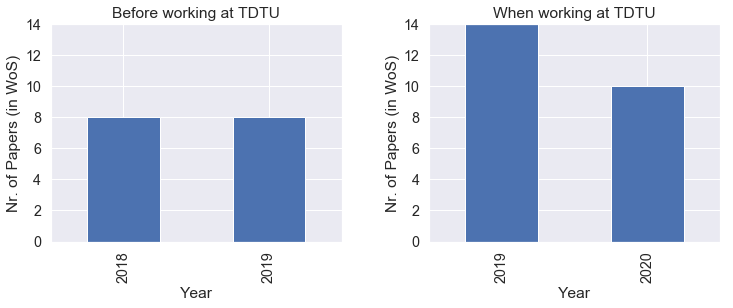

In [27]:
sns.set(font_scale=1.3)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

at_tdtu = df["Is_DMH_at_TDTU"]

df.loc[~at_tdtu, "Year"].value_counts().sort_index().plot(kind="bar", ax=ax[0])
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Nr. of Papers (in WoS)")
ax[0].set_ylim([0, 14])
ax[0].set_title("Before working at TDTU")

df.loc[at_tdtu, "Year"].value_counts().sort_index().plot(kind="bar", ax=ax[1])
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Nr. of Papers (in WoS)")
ax[1].set_title("When working at TDTU")
ax[1].set_ylim([0, 14])

In [ ]:
df_07_16 = df[df["Year"] <= 2016]
df_17_18 = df[(df["Year"] >= 2017) & (df["Year"] <= 2018)]
df_19_20 = df[df["Year"] >= 2019]

# Most frequent journals

In [ ]:
jour_07_16 = df_07_16["Journal-ISO"]
jour_17_18 = df_17_18["Journal-ISO"]
jour_19_20 = df_19_20["Journal-ISO"]

In [ ]:
sns.set(font_scale=1.2)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.6)

jour_07_16.value_counts()[:10].sort_values(ascending=True).plot(kind="barh", ax=ax[0])
ax[0].set_title("2007-2016")
ax[0].set_xlabel("frequency")

jour_17_18.value_counts()[:10].sort_values(ascending=True).plot(kind="barh", ax=ax[1])
ax[1].set_title("2017-2018")
ax[1].set_xlabel("frequency")

jour_19_20.value_counts()[:10].sort_values(ascending=True).plot(kind="barh", ax=ax[2])
ax[2].set_title("2019-2020")
ax[2].set_xlabel("frequency")

In [ ]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

wcl_07_16 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(jour_07_16.dropna().values))

ax[0].imshow(wcl_07_16, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("2007-2016")

wcl_17_18 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(jour_17_18.dropna().values))

ax[1].imshow(wcl_17_18, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("2017-2018")

wcl_19_20 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(jour_19_20.dropna().values))

ax[2].imshow(wcl_19_20, interpolation="bilinear")
ax[2].axis("off")
ax[2].set_title("2019-2020")

# Most common research areas

In [ ]:
res_areas_07_16 = []
for s in df_07_16["Research-Areas"].values:
    res_areas_07_16.extend(s.split(";"))

res_areas_07_16 = [s.strip() for s in res_areas_07_16]
res_areas_07_16 = [s.replace("\\", "") for s in res_areas_07_16]

In [ ]:
res_areas_17_18 = []
for s in df_17_18["Research-Areas"].values:
    res_areas_17_18.extend(s.split(";"))

res_areas_17_18 = [s.strip() for s in res_areas_17_18]
res_areas_17_18 = [s.replace("\\", "") for s in res_areas_17_18]

In [ ]:
res_areas_19_20 = []
for s in df_19_20["Research-Areas"].values:
    res_areas_19_20.extend(s.split(";"))

res_areas_19_20 = [s.strip() for s in res_areas_19_20]
res_areas_19_20 = [s.replace("\\", "") for s in res_areas_19_20]

In [ ]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

wcl_07_16 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(res_areas_07_16))

ax[0].imshow(wcl_07_16, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("2007-2016")

wcl_17_18 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(res_areas_17_18))

ax[1].imshow(wcl_17_18, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("2017-2018")

wcl_19_20 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(res_areas_19_20))

ax[2].imshow(wcl_19_20, interpolation="bilinear")
ax[2].axis("off")
ax[2].set_title("2019-2020")

# Most common Web-of-Science Categories

In [ ]:
wos_cat_07_16 = []
for s in df_07_16["Web-of-Science-Categories"].values:
    wos_cat_07_16.extend(s.split(";"))

wos_cat_07_16 = [s.strip() for s in wos_cat_07_16]
wos_cat_07_16 = [s.replace("\\", "") for s in wos_cat_07_16]

In [ ]:
wos_cat_17_18 = []
for s in df_17_18["Web-of-Science-Categories"].values:
    wos_cat_17_18.extend(s.split(";"))

wos_cat_17_18 = [s.strip() for s in wos_cat_17_18]
wos_cat_17_18 = [s.replace("\\", "") for s in wos_cat_17_18]

In [ ]:
wos_cat_19_20 = []
for s in df_19_20["Web-of-Science-Categories"].values:
    wos_cat_19_20.extend(s.split(";"))

wos_cat_19_20 = [s.strip() for s in wos_cat_19_20]
wos_cat_19_20 = [s.replace("\\", "") for s in wos_cat_19_20]

In [ ]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

wcl_07_16 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(wos_cat_07_16))

ax[0].imshow(wcl_07_16, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("2007-2016")

wcl_17_18 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(wos_cat_17_18))

ax[1].imshow(wcl_17_18, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("2017-2018")

wcl_19_20 = WordCloud(max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(wos_cat_19_20))

ax[2].imshow(wcl_19_20, interpolation="bilinear")
ax[2].axis("off")
ax[2].set_title("2019-2020")

# Most frequently occurring keywords

In [ ]:
kw_07_16 = []
for s in df_07_16["Keywords"].dropna().values:
    kw_07_16.extend(s.split(";"))
for s in df_07_16["Keywords-Plus"].dropna().values:
    kw_07_16.extend(s.split(";"))

kw_07_16 = [s.strip().lower() for s in kw_07_16]

In [ ]:
kw_17_18 = []
for s in df_17_18["Keywords"].dropna().values:
    kw_17_18.extend(s.split(";"))
for s in df_17_18["Keywords-Plus"].dropna().values:
    kw_17_18.extend(s.split(";"))

kw_17_18 = [s.strip().lower() for s in kw_17_18]

In [ ]:
kw_19_20 = []
for s in df_19_20["Keywords"].dropna().values:
    kw_19_20.extend(s.split(";"))
for s in df_19_20["Keywords-Plus"].dropna().values:
    kw_19_20.extend(s.split(";"))

kw_19_20 = [s.strip().lower() for s in kw_19_20]
kw_19_20 = ["nanoparticle" if s=="nanoparticles" else s for s in kw_19_20]

In [ ]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

wcl_07_16 = WordCloud(max_words=25, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(kw_07_16))

ax[0].imshow(wcl_07_16, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("2007-2016")

wcl_17_18 = WordCloud(max_words=25, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(kw_17_18))

ax[1].imshow(wcl_17_18, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("2017-2018")

wcl_19_20 = WordCloud(max_words=25, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(kw_19_20))

ax[2].imshow(wcl_19_20, interpolation="bilinear")
ax[2].axis("off")
ax[2].set_title("2019-2020")

# Most frequent co-corresponding authors by email
Among papers in which N.T.K. is a corresponding author, who else are also corresponding author?

In [ ]:
em_07_16 = []
for s in df_07_16.loc[df_07_16["NTK_is_Corresp_Aut"]==True, "Author-Email"].dropna().values:
    em_07_16.extend(s.split())

em_07_16 = [s.strip() for s in em_07_16]
em_07_16 = [s for s in em_07_16 if "nguyentruongkhang" not in s]

In [ ]:
em_17_18 = []
for s in df_17_18.loc[df_17_18["NTK_is_Corresp_Aut"]==True, "Author-Email"].dropna().values:
    em_17_18.extend(s.split())

em_17_18 = [s.strip() for s in em_17_18]
em_17_18 = [s for s in em_17_18 if "nguyentruongkhang" not in s]

In [ ]:
em_19_20 = []
for s in df_19_20.loc[df_19_20["NTK_is_Corresp_Aut"]==True,"Author-Email"].dropna().values:
    em_19_20.extend(s.split())

em_19_20 = [s.strip() for s in em_19_20]
em_19_20 = [s for s in em_19_20 if "nguyentruongkhang" not in s]

In [ ]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

wcl_07_16 = WordCloud(max_words=15, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(em_07_16))

ax[0].imshow(wcl_07_16, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("2007-2016")

wcl_17_18 = WordCloud(max_words=15, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(em_17_18))

ax[1].imshow(wcl_17_18, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("2017-2018")

wcl_19_20 = WordCloud(max_words=15, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(em_19_20))

ax[2].imshow(wcl_19_20, interpolation="bilinear")
ax[2].axis("off")
ax[2].set_title("2019-2020")

# Most frequent co-authors by name

In [ ]:
exclude_names = ["Nguyen Truong Khang", "Truong Khang Nguyen", "Nguyen, Truong Khang"]

In [ ]:
au_07_16 = []
for s in df_07_16["Author"].dropna().values:
    au_07_16.extend(s.split("and"))

au_07_16 = [s.strip() for s in au_07_16]
au_07_16 = [s for s in au_07_16 if s not in exclude_names]

In [ ]:
au_17_18 = []
for s in df_17_18["Author"].dropna().values:
    au_17_18.extend(s.split("and"))

au_17_18 = [s.strip() for s in au_17_18]
au_17_18 = [s for s in au_17_18 if s not in exclude_names]

In [ ]:
au_19_20 = []
for s in df_19_20["Author"].dropna().values:
    au_19_20.extend(s.split("and"))

au_19_20 = [s.strip() for s in au_19_20]
au_19_20 = [s for s in au_19_20 if s not in exclude_names]

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

wcl_07_16 = WordCloud(max_words=20, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(au_07_16))

ax[0].imshow(wcl_07_16, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("2007-2016")

wcl_17_18 = WordCloud(max_words=20, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(au_17_18))

ax[1].imshow(wcl_17_18, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("2017-2018")

wcl_19_20 = WordCloud(max_words=20, max_font_size=200, width=800, background_color="white").generate_from_frequencies(
    Counter(au_19_20))

ax[2].imshow(wcl_19_20, interpolation="bilinear")
ax[2].axis("off")
ax[2].set_title("2019-2020")